In [1]:
import torch
from matplotlib import pyplot as plt

import os

def search_files(directories):
    files = []
    for directory in directories:
        if os.path.isdir(directory):
            file_names = os.listdir(directory)
            for file_name in file_names:
                files.append(os.path.join(directory, file_name))
    return files

def find_events_files(directories):
    events_files = []
    
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if "events" in file:
                    events_files.append(file)
                    break
    
    return events_files

In [2]:
#!/usr/bin/env python3

import glob
import os
import pprint
import traceback

import click

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs


@click.command()
@click.argument("logdir-or-logfile")
@click.option(
    "--write-pkl/--no-write-pkl", help="save to pickle file or not", default=False
)
@click.option(
    "--write-csv/--no-write-csv", help="save to csv file or not", default=True
)
@click.option("--out-dir", "-o", help="output directory", default=".")
def main(logdir_or_logfile: str, write_pkl: bool, write_csv: bool, out_dir: str):
    """This is a enhanced version of
    https://gist.github.com/ptschandl/ef67bbaa93ec67aba2cab0a7af47700b
    This script exctracts variables from all logs from tensorflow event
    files ("event*"),
    writes them to Pandas and finally stores them a csv-file or
    pickle-file including all (readable) runs of the logging directory.
    Example usage:
    # create csv file from all tensorflow logs in provided directory (.)
    # and write it to folder "./converted"
    tflogs2pandas.py . --write-csv --no-write-pkl --o converted
    # creaste csv file from tensorflow logfile only and write into
    # and write it to folder "./converted"
    tflogs2pandas.py tflog.hostname.12345 --write-csv --no-write-pkl --o converted
    """
    pp = pprint.PrettyPrinter(indent=4)
    if os.path.isdir(logdir_or_logfile):
        # Get all event* runs from logging_dir subdirectories
        event_paths = glob.glob(os.path.join(logdir_or_logfile, "event*"))
    elif os.path.isfile(logdir_or_logfile):
        event_paths = [logdir_or_logfile]
    else:
        raise ValueError(
            "input argument {} has to be a file or a directory".format(
                logdir_or_logfile
            )
        )
    # Call & append
    if event_paths:
        pp.pprint("Found tensorflow logs to process:")
        pp.pprint(event_paths)
        all_logs = many_logs2pandas(event_paths)
        pp.pprint("Head of created dataframe")
        pp.pprint(all_logs.head())

        os.makedirs(out_dir, exist_ok=True)
        if write_csv:
            print("saving to csv file")
            out_file = os.path.join(out_dir, "all_training_logs_in_one_file.csv")
            print(out_file)
            all_logs.to_csv(out_file, index=None)
        if write_pkl:
            print("saving to pickle file")
            out_file = os.path.join(out_dir, "all_training_logs_in_one_file.pkl")
            print(out_file)
            all_logs.to_pickle(out_file)
    else:
        print("No event paths have been found.")



In [3]:
runs = ['ms_models/0','ms_models/1','ms_models/2',
        'ss_models/0','ss_models/1','ss_models/2',
        'no_pretraining/0','no_pretraining/1','no_pretraining/2']

tb_files = [f'/home/mrudolph/documents/actbisim/scripts_nav2d/rl_models/{model}/' for model in runs]

# find_events_files([tb_files[0]])
tb_files = {runs[idx]:tb_files[idx]+file_name for  idx, file_name in  enumerate(find_events_files(tb_files))}
print(tb_files.keys())

dict_keys(['ms_models/0', 'ms_models/1', 'ms_models/2', 'ss_models/0', 'ss_models/1', 'ss_models/2', 'no_pretraining/0', 'no_pretraining/1', 'no_pretraining/2'])


In [10]:
frames = []
for tb_file in tb_files.keys():
    dft = tflog2pandas(tb_files[tb_file])
    dft.insert(3, "run", [tb_file[-1]] * dft.shape[0], True)
    dft.insert(4, "type", [tb_file[:-2]] * dft.shape[0], True)
    dft.insert(5, "stept", np.arange(0, dft.shape[0]), True)
    dft = dft[dft['metric'] == 'ep_rew'][::100]
    print(tb_file)
    frames.append(dft)
    
dft = pd.concat(frames)

ms_models/0
ms_models/1
ms_models/2
ss_models/0
ss_models/1
ss_models/2
no_pretraining/0
no_pretraining/1
no_pretraining/2


       metric  value      step run            type  stept
0      ep_rew  -38.0      39.0   0       ms_models      0
100    ep_rew  -50.0    5009.0   0       ms_models    100
200    ep_rew  -50.0    9950.0   0       ms_models    200
300    ep_rew  -50.0   14335.0   0       ms_models    300
400    ep_rew  -50.0   18487.0   0       ms_models    400
...       ...    ...       ...  ..             ...    ...
19500  ep_rew  -32.0  533863.0   2  no_pretraining  19500
19600  ep_rew  -26.0  536304.0   2  no_pretraining  19600
19700  ep_rew  -26.0  538659.0   2  no_pretraining  19700
19800  ep_rew  -14.0  541005.0   2  no_pretraining  19800
19900  ep_rew  -19.0  543412.0   2  no_pretraining  19900

[1800 rows x 6 columns]


<Axes: xlabel='stept', ylabel='value'>

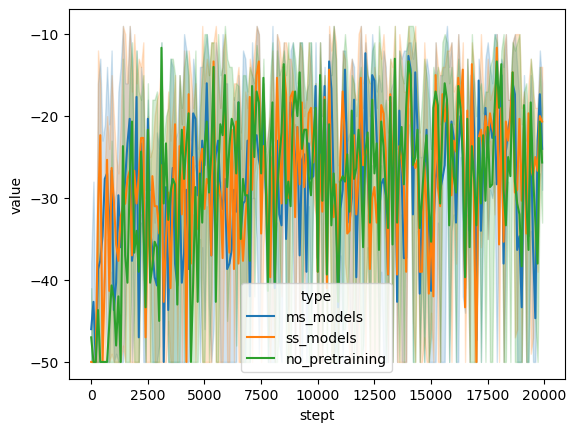

In [11]:
print(dft)
sns.lineplot(data=dft, x="stept", y="value", hue="type")

(3, 220)


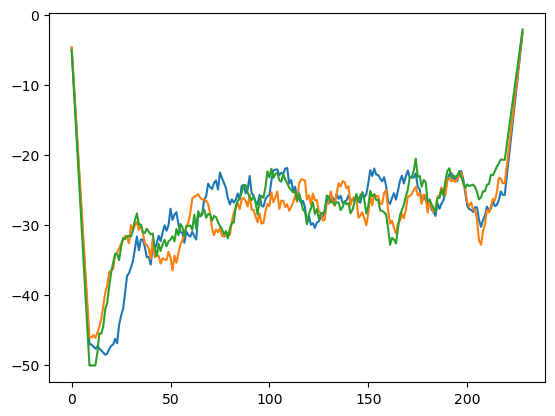

In [51]:
results_dict = {} 
runs = ['no_pretraining', 'ms_models', 'ss_models']
npt = {rtype:[dft.query(f"type == '{rtype}' and run == '{i}'")["value"].values for i in range(3)] for rtype in runs}

rews = np.zeros((3, 3, 235))

for i in range(3):
    for j in range(3):
        rews[i,j,:npt[runs[i]][j].shape[0]] = npt[runs[i]][j]
        

mean_rews = np.mean(rews, axis=1)[:,:200]

window_size = 10  # Adjust the window size as desired

meanstart = mean_rews[:, [0]]
meanend = mean_rews[:, [-1]]
msr = np.repeat(meanstart, [window_size]).reshape(3,-1)
mer = np.repeat(meanend, [window_size]).reshape(3,-1)

filt = np.concatenate((msr, mean_rews, mer), axis=1)
print(filt.shape)
# Calculate the running average along the second dimension
running_avg = np.array([np.convolve(mean_rew, np.ones(window_size) / window_size) for mean_rew in filt])

plt.plot(running_avg.T)

In [48]:
mean_rews.shape

meanstart = mean_rews[:, [0]]
meanend = mean_rews[:, [-1]]
msr = np.repeat(meanstart, [window_size]).reshape(3,-1)
mer = np.repeat(meanend, [window_size]).reshape(3,-1)

filt = np.concatenate((msr, mean_rews, mer), axis=1)


(3, 208)
